# Initialize Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl
from sklearn.decomposition import PCA

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/02


In [2]:
sys.path.append('../python/')
from filterMethods import *
from trackReconstructionMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

In [3]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [4]:
fileName = '../runs/event_2mu100MeVBackToBack_usedForTrackReconstruction.root'
histDir = '/photoSensor_hits_histograms'
print(get_histogram_names    (fileName, histDir))
print(get_histogram_titles   (fileName, histDir))
print(get_histogram_positions(fileName, histDir))
print(get_histogram_walls    (fileName, histDir))

['photoSensor_0;1', 'photoSensor_1;1', 'photoSensor_2;1', 'photoSensor_3;1', 'photoSensor_4;1', 'photoSensor_5;1', 'photoSensor_6;1', 'photoSensor_7;1', 'photoSensor_8;1', 'photoSensor_9;1', 'photoSensor_10;1', 'photoSensor_11;1', 'photoSensor_12;1', 'photoSensor_13;1', 'photoSensor_14;1', 'photoSensor_15;1', 'photoSensor_16;1', 'photoSensor_17;1', 'photoSensor_18;1', 'photoSensor_19;1', 'photoSensor_20;1', 'photoSensor_21;1', 'photoSensor_22;1', 'photoSensor_23;1', 'photoSensor_24;1', 'photoSensor_25;1', 'photoSensor_26;1', 'photoSensor_27;1', 'photoSensor_28;1', 'photoSensor_29;1', 'photoSensor_30;1', 'photoSensor_31;1', 'photoSensor_32;1', 'photoSensor_33;1', 'photoSensor_34;1', 'photoSensor_35;1', 'photoSensor_36;1', 'photoSensor_37;1', 'photoSensor_38;1', 'photoSensor_39;1', 'photoSensor_40;1', 'photoSensor_41;1', 'photoSensor_42;1', 'photoSensor_43;1', 'photoSensor_44;1', 'photoSensor_45;1', 'photoSensor_46;1', 'photoSensor_47;1', 'photoSensor_48;1', 'photoSensor_49;1', 'photoSen

In [5]:
treeName = 'photoSensor_hits;1'
df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'            ] = get_photosensor_hits_photosensor_ID          (fileName, treeName)
df_hits['sensor_direction'       ] = get_photosensor_hits_photosensor_direction   (fileName, treeName)
df_hits['sensor_position'        ] = get_photosensor_hits_photosensor_position    (fileName, treeName)
df_hits['relativePosition'       ] = get_photosensor_hits_position_relative       (fileName, treeName)
df_hits['relativePosition_binned'] = get_photosensor_hits_position_relative_binned(fileName, treeName, histDir)
df_hits['relativePosition_nBin'  ] = get_photosensor_hits_position_relative_nBin  (fileName, treeName, histDir)
df_hits['initialPosition'        ] = get_photosensor_hits_position_initial        (fileName, treeName)
df_hits['time'                   ] = get_photosensor_hits_time                    (fileName, treeName)
print('df_hits length:', len(df_hits))

df_hits length: 10970


In [6]:
treeName = 'primary;1'
df_primary = pd.DataFrame(columns=['position', 'time'])
df_primary['position'] = get_primary_position(fileName, treeName)
df_primary['time'    ] = get_primary_time    (fileName, treeName)
print('df_primary length:', len(df_primary))

df_primary length: 6847


# Filter Hits

In [7]:
search_radius = 0
search_number = 0

df_hits = filter_hits(df_hits, radius=search_radius, number=search_number)

# Basic Hit Reco

In [8]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)
df_hits = make_r(df_hits)
df_hits = filter_r(df_hits, Y_LIM)
df_hits = make_theta(df_hits, rToTheta)
df_hits = make_phi(df_hits)
df_hits = make_reconstructedVector_direction(df_hits)
df_hits = make_relativeVector(df_hits)  

  0%|          | 0/10970 [00:00<?, ?it/s]

100%|██████████| 9270/9270 [00:00<00:00, 75046.61it/s]


# Make or Load Grid

In [9]:
gridSize = (40, 40, 40)
makeErrors = False
plotRecoName = '{}x{}x{}_{}_{}'.format(gridSize[0], gridSize[1], gridSize[2], fileName.split('/')[-1].split('.')[0], {True:'withErrors', False:'noErrors'}[makeErrors])
print('plotRecoName:', plotRecoName)

plotRecoName: 40x40x40_event_2mu100MeVBackToBack_usedForTrackReconstruction_noErrors


In [10]:
grid, grid_ind, grid_pos = get_voxelGrid(
    gridSize,
    DETECTOR_SIZE_MM,
    np.array(df_hits['sensor_position'].to_list()).reshape(-1,3),
    np.array(df_hits['reconstructedVector_direction'].to_list()).reshape(-1,3),
    [1 for i in range(len(df_hits))],
    20,
    makeErrors
)
np.savez('data/{}.npz'.format(plotRecoName), grid=grid, grid_ind=grid_ind, grid_pos=grid_pos)

100%|██████████| 9270/9270 [6:25:56<00:00,  2.50s/it]      


In [11]:
data = np.load('data/{}.npz'.format(plotRecoName))
grid     = data['grid'    ]
# grid = get_voxelGrid_errors(grid)
grid_ind = data['grid_ind']
grid_pos = data['grid_pos']

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_81364/1266356935.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


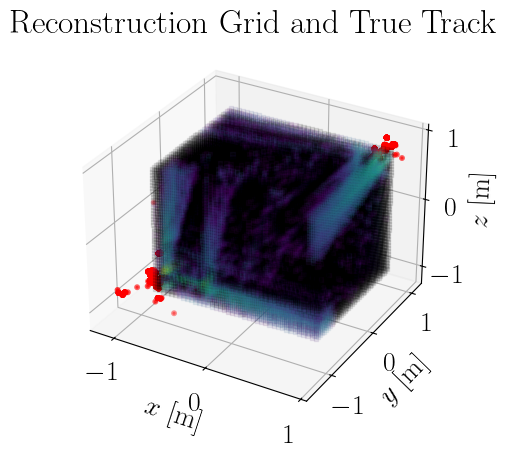

In [12]:
# %matplotlib qt
# %matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
voxelGrid = ax.scatter(grid_pos[:,0]/1000,
                       grid_pos[:,1]/1000,
                       grid_pos[:,2]/1000,  
                       c=grid[grid >= 0],
                       cmap='viridis',
                       marker='s',
                       alpha=0.10,
                       s=10,
                       norm=LogNorm())  # Use LogNorm for log scale
track = ax.scatter(np.array(df_primary['position'].to_list()).reshape(-1,3)[:,0]/1000,
                   np.array(df_primary['position'].to_list()).reshape(-1,3)[:,1]/1000,
                   np.array(df_primary['position'].to_list()).reshape(-1,3)[:,2]/1000,
                   c='r',
                   marker='o',
                   s=5,
                   label='True Track',
                   linewidth=2)
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_title('Reconstruction Grid and True Track')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm())
sm.set_array(grid[grid > 0])
# cbar = fig.colorbar(sm, ax=ax, label='Color Bar (Log Scale)')
# fig.legend(loc='upper right', bbox_to_anchor=(1.05, 0.9))
fig.savefig('../figures/trackReconstruction_gridAndTrack_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()

In [13]:
primary_true = np.array(df_primary['position'].to_list()).reshape(-1,3)
primary_true = primary_true[np.where((primary_true[:, 0] <  DETECTOR_SIZE_MM[0]/2) & (primary_true[:, 1] < DETECTOR_SIZE_MM[1]/2) & (primary_true[:, 2] < DETECTOR_SIZE_MM[2]/2) & 
                                     (primary_true[:, 0] > -DETECTOR_SIZE_MM[0]/2) & (primary_true[:, 1] > -DETECTOR_SIZE_MM[1]/2) & (primary_true[:, 2] > -DETECTOR_SIZE_MM[2]/2))]
# primary_true = primary_true[np.where((primary_true[:, 0] < np.max(X_mean[:,0])) & (primary_true[:, 1] < np.max(X_mean[:,1])) & (primary_true[:, 2] < np.max(X_mean[:,2]))
#                                    & (primary_true[:, 0] > np.min(X_mean[:,0])) & (primary_true[:, 1] > np.min(X_mean[:,1])) & (primary_true[:, 2] > np.min(X_mean[:,2])))]

# Plotting Methods

In [14]:
def plotSlice(grid, pos, i, axis, size_1, size_2, ax=None, show=True, save=False, saveName='test.png'):
    if ax is None:
        fig, ax = plt.subplots()

    if axis == 0:
        slice = grid[i,:,:]
    elif axis == 1:
        slice = grid[:,i,:]
    elif axis == 2:
        slice = grid[:,:,i]

    imshow = ax.imshow(slice, cmap='viridis', extent=[-size_1/2, size_1/2, size_2/2, -size_2/2])
    ax.scatter(pos[i,0], pos[i,1], c='r', marker='o', s=20)
    cbar = ax.figure.colorbar(imshow, ax=ax, label='Color Bar (Log Scale)')

    if show:
        plt.show()
    if save:
        plt.savefig(saveName)

    plt.close(fig)

def makeAnimation(grid, pos, axis, size_1, size_2, save=False, saveName='test.gif'):
    fig, ax = plt.subplots()

    def update(i):
        ax.clear()
        if axis == 0:
            slice = grid[i,:,:]
        elif axis == 1:
            slice = grid[:,i,:]
        elif axis == 2:
            slice = grid[:,:,i]
            
        imshow = ax.imshow(slice, cmap='viridis', extent=[-size_1/2, size_1/2, size_2/2, -size_2/2])
        ax.scatter(pos[i,0], pos[i,1], c='r', marker='o', s=20)
        # cbar = ax.figure.colorbar(imshow, ax=ax, label='Color Bar (Log Scale)')
        return imshow
        
    anim = FuncAnimation(fig, update, frames=grid.shape[0], interval=100)
    anim.save(saveName, dpi=80, writer='imagemagick')
    return anim


# Mean Slice Reconstruction

In [15]:
showPlots = False
savePlots = False
saveAnima = False
saveDir = '../figures/voxelGrid_mean_{}'.format(plotRecoName)

pos_avg = np.zeros((grid.shape[0], 2))
for x in np.arange(grid.shape[0]):
    val_y = np.mean(grid[x,:,:], axis=0)
    val_z = np.mean(grid[x,:,:], axis=1)
    if np.sum(val_y) == 0 or np.sum(val_z) == 0:
        continue
    pos = grid_pos[np.where(grid_ind[:,0] == x)][:,1:3]
    pos_avg[x,0] = np.average(np.unique(pos[:,0]), weights=val_y)
    pos_avg[x,1] = np.average(np.unique(pos[:,1]), weights=val_z)
    plotSlice(grid, pos_avg, x, 0, DETECTOR_SIZE_Y_MM, DETECTOR_SIZE_Z_MM, show=showPlots, save=savePlots, saveName='{}/x_{}.pdf'.format(saveDir, x))
if saveAnima:
    makeAnimation(grid, pos_avg, 0, DETECTOR_SIZE_Y_MM, DETECTOR_SIZE_Z_MM, save=savePlots, saveName='{}/x.gif'.format(saveDir))
X_mean = np.array([np.unique(grid_pos[:,0]), pos_avg[:,0], pos_avg[:,1]]).T

pos_avg = np.zeros((grid.shape[1], 2))
for y in np.arange(grid.shape[1]):
    val_x = np.mean(grid[:,y,:], axis=0)
    val_z = np.mean(grid[:,y,:], axis=1)
    if np.sum(val_x) == 0 or np.sum(val_z) == 0:
        continue
    pos = grid_pos[np.where(grid_ind[:,1] == y)][:,[0,2]]
    pos_avg[y,0] = np.average(np.unique(pos[:,0]), weights=val_x)
    pos_avg[y,1] = np.average(np.unique(pos[:,1]), weights=val_z)
    plotSlice(grid, pos_avg, y, 1, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Z_MM, show=showPlots, save=savePlots, saveName='{}/y_{}.pdf'.format(saveDir, y))
if saveAnima:
    makeAnimation(grid, pos_avg, 1, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Z_MM, save=savePlots, saveName='{}/y.gif'.format(saveDir))
Y_mean = np.array([pos_avg[:,0], np.unique(grid_pos[:,1]), pos_avg[:,1]]).T

pos_avg = np.zeros((grid.shape[2],2))
for z in np.arange(grid.shape[2]):
    val_x = np.mean(grid[:,:,z], axis=0)
    val_y = np.mean(grid[:,:,z], axis=1)
    if np.sum(val_x) == 0 or np.sum(val_y) == 0:
        continue
    pos = grid_pos[np.where(grid_ind[:,2] == z)][:,:2]
    pos_avg[z,0] = np.average(np.unique(pos[:,0]), weights=val_x)
    pos_avg[z,1] = np.average(np.unique(pos[:,1]), weights=val_y)
    plotSlice(grid, pos_avg, z, 2, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Y_MM, show=showPlots, save=savePlots, saveName='{}/z_{}.pdf'.format(saveDir, z))
if saveAnima:
    makeAnimation(grid, pos_avg, 2, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Y_MM, save=savePlots, saveName='{}/z.gif'.format(saveDir))
Z_mean = np.array([pos_avg[:,0], pos_avg[:,1], np.unique(grid_pos[:,2])]).T

avg_mean = np.mean(np.array([X_mean,Y_mean,Z_mean]), axis=0)

In [16]:
####################################################
##### this is the old method that is incorrect #####
####################################################

# showPlots = False
# savePlots = False
# saveAnima = False
# saveDir = '../figures/voxelGrid_mean_{}'.format(plotRecoName)

# pos_avg = np.zeros((grid.shape[0], 2))
# for x in np.arange(grid.shape[0]):
#     val = grid[x,:,:].flatten()
#     if np.sum(val) == 0:
#         continue
#     pos = grid_pos[np.where(grid_ind[:,0] == x)][:,:2]
#     pos_avg[x,0] = np.average(pos[:,0], weights=val)
#     pos_avg[x,1] = np.average(pos[:,1], weights=val)
#     plotSlice(grid, pos_avg, x, 0, DETECTOR_SIZE_Y_MM, DETECTOR_SIZE_Z_MM, show=showPlots, save=savePlots, saveName='{}/x_{}.pdf'.format(saveDir, x))
# if saveAnima:
#     makeAnimation(grid, pos_avg, 0, DETECTOR_SIZE_Y_MM, DETECTOR_SIZE_Z_MM, save=savePlots, saveName='{}/x.gif'.format(saveDir))
# X_mean = np.array([np.unique(grid_pos[:,0]), pos_avg[:,0], pos_avg[:,1]]).T

# pos_avg = np.zeros((grid.shape[1], 2))
# for y in np.arange(grid.shape[1]):
#     val = grid[:,y,:].flatten()
#     if np.sum(val) == 0:
#         continue
#     pos = grid_pos[np.where(grid_ind[:,1] == y)][:,:2]
#     pos_avg[y,0] = np.average(pos[:,0], weights=val)
#     pos_avg[y,1] = np.average(pos[:,1], weights=val)
#     plotSlice(grid, pos_avg, y, 1, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Z_MM, show=showPlots, save=savePlots, saveName='{}/y_{}.pdf'.format(saveDir, y))
# if saveAnima:
#     makeAnimation(grid, pos_avg, 1, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Z_MM, save=savePlots, saveName='{}/y.gif'.format(saveDir))
# Y_mean = np.array([pos_avg[:,0], np.unique(grid_pos[:,1]), pos_avg[:,1]]).T

# pos_avg = np.zeros((grid.shape[2],2))
# for z in np.arange(grid.shape[2]):
#     val = grid[:,:,z].flatten()
#     if np.sum(val) == 0:
#         continue
#     pos = grid_pos[np.where(grid_ind[:,2] == z)][:,:2]
#     pos_avg[z,0] = np.average(pos[:,0], weights=val)
#     pos_avg[z,1] = np.average(pos[:,1], weights=val)
#     plotSlice(grid, pos_avg, z, 2, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Y_MM, show=showPlots, save=savePlots, saveName='{}/z_{}.pdf'.format(saveDir, z))
# if saveAnima:
#     makeAnimation(grid, pos_avg, 2, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Y_MM, save=savePlots, saveName='{}/z.gif'.format(saveDir))
# Z_mean = np.array([pos_avg[:,0], pos_avg[:,1], np.unique(grid_pos[:,2])]).T

# avg_mean = np.mean(np.array([X_mean,Y_mean,Z_mean]), axis=0)

In [17]:
# pts_lin = avg_mean.copy()

# pca = PCA(n_components=1)
# pca.fit(pts_lin)

# intercept = np.mean(pts_lin, axis=0)  # Use the mean as the intercept
# direction = pca.components_[0]

# pts_lin = np.outer(pts_lin[:,0], direction) + intercept

# pts_min = np.min(df_primary['position'].to_list()) #np.min(pts[:,0])
# pts_max = np.max(df_primary['position'].to_list()) #np.max(pts[:,0])

# pts_length = pts_max - pts_min
# pts_lin_length = np.max(pts_lin[:,0]) - np.min(pts_lin[:,0])
# pts_lin = pts_lin * pts_length / pts_lin_length - (pts_min - np.min(pts_lin[:,0]) * pts_length / pts_lin_length)

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_81364/2240039819.py:72: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


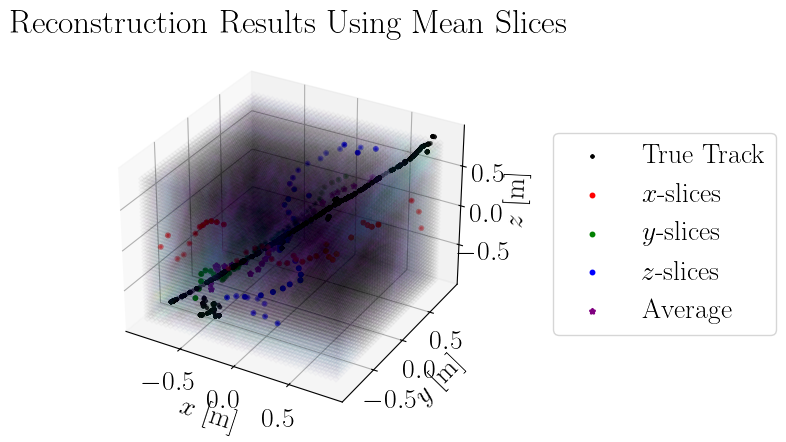

In [18]:
# %matplotlib qt
# %matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
voxelGrid = ax.scatter(grid_pos[:,0]/1000,
                       grid_pos[:,1]/1000,
                       grid_pos[:,2]/1000,
                       c=grid[grid >= 0],
                       cmap='viridis',
                       marker='D',
                       alpha=0.02,
                       s=10,
                       norm=LogNorm())  # Use LogNorm for log scale
track_true = ax.scatter(primary_true[:,0]/1000,
                        primary_true[:,1]/1000,
                        primary_true[:,2]/1000,
                        c='black',
                        marker='x',
                        s=5,
                        label='True Track',
                        linewidth=2)
track_reco_X = ax.scatter(X_mean[:,0]/1000,
                          X_mean[:,1]/1000,
                          X_mean[:,2]/1000,
                          c='r',
                          marker='o',
                          s=5,
                          label='$x$-slices',
                          linewidth=2)
track_reco_Y = ax.scatter(Y_mean[:,0]/1000,
                          Y_mean[:,1]/1000,
                          Y_mean[:,2]/1000,
                          c='g',
                          marker='o',
                          s=5,
                          label='$y$-slices',
                          linewidth=2)
track_reco_Z = ax.scatter(Z_mean[:,0]/1000,
                          Z_mean[:,1]/1000,
                          Z_mean[:,2]/1000,
                          c='b',
                          marker='o',
                          s=5,
                          label='$z$-slices',
                          linewidth=2)
track_reco = ax.scatter(avg_mean[:,0]/1000,
                        avg_mean[:,1]/1000,
                        avg_mean[:,2]/1000,
                        c='purple',
                        marker='*',
                        s=10,
                        label='Average',
                        linewidth=2)
# track_reco_line = ax.plot(pts_lin[:,0],
#                           pts_lin[:,1],
#                           pts_lin[:,2],
#                           c='gray',
#                           marker='o',
#                           markersize=5,
#                           label='pts_lin',
#                           linewidth=2)
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_title('Reconstruction Results Using Mean Slices')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm())
sm.set_array(grid[grid > 0])
ax.legend(loc='center right', bbox_to_anchor=(1.8, 0.5))
# cbar = fig.colorbar(sm, ax=ax, label='Color Bar (Log Scale)')
fig.savefig('../figures/trackReconstruction_mean_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_81364/328158631.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


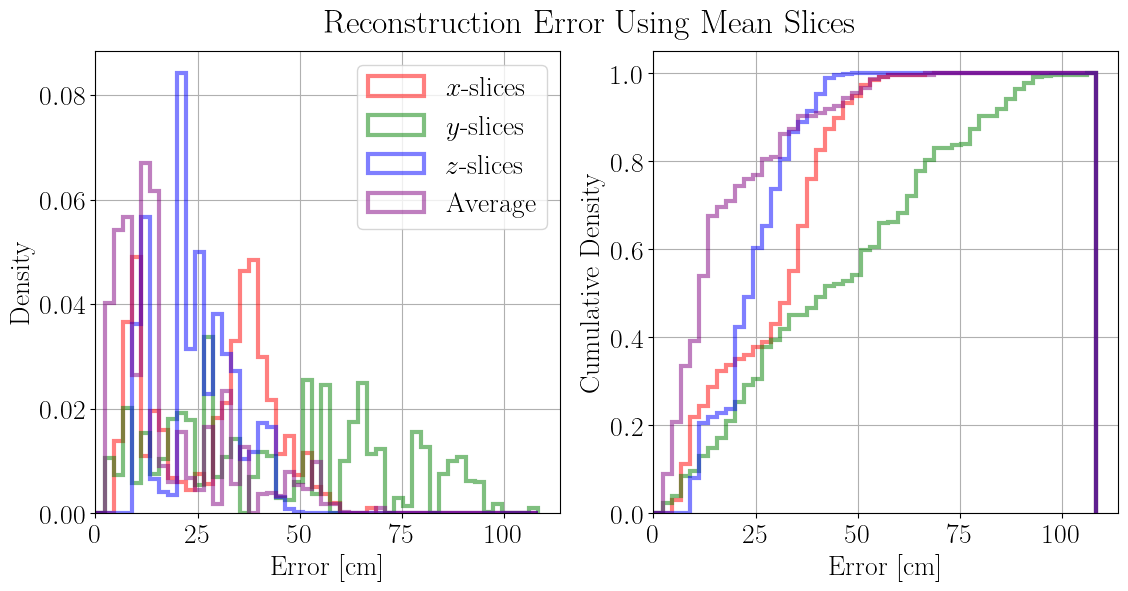

In [19]:
# %matplotlib inline

distances_X = cdist(primary_true, X_mean)
distances_X = np.min(distances_X, axis=1)

distances_Y = cdist(primary_true, Y_mean)
distances_Y = np.min(distances_Y, axis=1)

distances_Z = cdist(primary_true, Z_mean)
distances_Z = np.min(distances_Z, axis=1)

distances_pts = cdist(primary_true, avg_mean)
distances_pts = np.min(distances_pts, axis=1)

# pts_lin_true = np.array(df_primary['position'].to_list()).reshape(-1,3)
# pts_lin_true = pts_lin_true[np.where((pts_lin_true[:, 0] < np.max(pts_lin[:,0])) & (pts_lin_true[:, 1] < np.max(pts_lin[:,1])) & (pts_lin_true[:, 2] < np.max(pts_lin[:,2]))
#                                    & (pts_lin_true[:, 0] > np.min(pts_lin[:,0])) & (pts_lin_true[:, 1] > np.min(pts_lin[:,1])) & (pts_lin_true[:, 2] > np.min(pts_lin[:,2])))]
# distances_pts_lin = cdist(np.array(df_primary['position'].to_list()).reshape(-1,3), pts_lin)
# distances_pts_lin = np.min(distances_pts_lin, axis=1)

fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(13.2, 6))
scale = 10
lw = 3
bins = np.linspace(0, np.max([np.max(distances_X/scale), np.max(distances_Y/scale), np.max(distances_Z/scale), np.max(distances_pts/scale)]), 50)

ax_1.hist(distances_X  /scale, bins=bins, color='r'     , alpha=0.5, label='$x$-slices', histtype='step', cumulative=False, density=True, linewidth=lw)
ax_1.hist(distances_Y  /scale, bins=bins, color='g'     , alpha=0.5, label='$y$-slices', histtype='step', cumulative=False, density=True, linewidth=lw)
ax_1.hist(distances_Z  /scale, bins=bins, color='b'     , alpha=0.5, label='$z$-slices', histtype='step', cumulative=False, density=True, linewidth=lw)
ax_1.hist(distances_pts/scale, bins=bins, color='purple', alpha=0.5, label='Average'   , histtype='step', cumulative=False, density=True, linewidth=lw)

ax_2.hist(distances_X  /scale, bins=bins, color='r'     , alpha=0.5, label='$x$-slices', histtype='step', cumulative=True, density=True, linewidth=lw)
ax_2.hist(distances_Y  /scale, bins=bins, color='g'     , alpha=0.5, label='$y$-slices', histtype='step', cumulative=True, density=True, linewidth=lw)
ax_2.hist(distances_Z  /scale, bins=bins, color='b'     , alpha=0.5, label='$z$-slices', histtype='step', cumulative=True, density=True, linewidth=lw)
ax_2.hist(distances_pts/scale, bins=bins, color='purple', alpha=0.5, label='Average'   , histtype='step', cumulative=True, density=True, linewidth=lw)

# ax.hist(distances_pts_lin, bins=bins, color='gray', alpha=0.5, label='pts_lin', histtype='step', cumulative=cum, density=True, linewidth=2)

fig.suptitle('Reconstruction Error Using Mean Slices', y=0.95)

ax_1.set_xlabel('Error [cm]')
ax_1.set_ylabel('Density')
ax_1.set_xlim(xmin=0)
ax_1.grid()
ax_1.legend(loc='upper right')

ax_2.set_xlabel('Error [cm]')
ax_2.set_ylabel('Cumulative Density')
ax_2.set_xlim(xmin=0)
ax_2.grid()

fig.savefig('../figures/trackReconstruction_meanError_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()

100%|██████████| 9270/9270 [00:00<00:00, 75643.62it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_81364/264419730.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


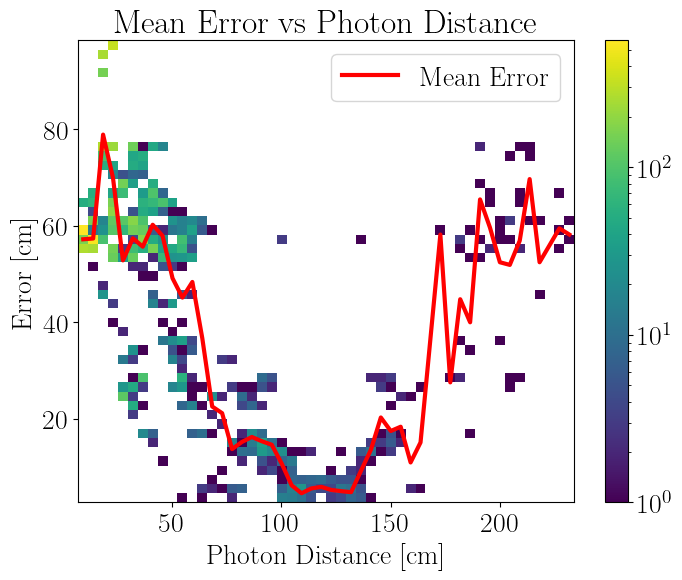

In [20]:
relativeVectors = []
errors = []
for i in tqdm.tqdm(range(len(df_hits))):
    relativeVectors.append(df_hits['relativeVector_r'].iloc[i]/scale)
    initialPosition = df_hits['initialPosition'].iloc[i]
    error = cdist([initialPosition], avg_mean)
    error = np.min(error, axis=1)[0]/scale
    errors.append(error)
relativeVectors = np.array(relativeVectors)
errors = np.array(errors)

fig, ax = plt.subplots(figsize=(8, 6))
h, xedges, yedges, _ = ax.hist2d(
    relativeVectors,
    errors,
    norm=LogNorm(),
    bins=50
)
yaverage = []
xaverage = []
for i in range(h.shape[1]):
    if np.sum(h[i,:]) != 0:
        yaverage.append(np.average(yedges[:-1], weights=h[i,:]))
        xaverage.append(xedges[i] + (xedges[i+1] - xedges[i])/2)

ax.plot(
    xaverage,
    yaverage,
    color='r',
    linewidth=3,
    label='Mean Error'
)
ax.set_xlabel('Photon Distance [cm]')
ax.set_ylabel('Error [cm]')
ax.set_title('Mean Error vs Photon Distance')
fig.colorbar(ax.collections[0]) 
ax.legend(loc='upper right')

fig.savefig('../figures/trackReconstruction_meanErrorVsPhotonDistance_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()

# Max Slice Reconstruction

In [21]:
showPlots = False
savePlots = False
saveAnima = False
saveDir = '../figures/voxelGrid_max/'

pos_max = np.zeros((grid.shape[0], 2))
for x in np.arange(grid.shape[0]):
    pos = grid_pos[np.where(grid_ind[:,0] == x)][:,[2,1]] # detector must be symetric
    pos_max[x] = pos[np.argmax(np.reshape(grid[x,:,:], -1))]
    plotSlice(grid, pos_max, x, 0, DETECTOR_SIZE_Y_MM, DETECTOR_SIZE_Z_MM, show=showPlots, save=savePlots, saveName='{}/x_{}.pdf'.format(saveDir, x))
if saveAnima:
    makeAnimation(grid, pos_max,    0, DETECTOR_SIZE_Y_MM, DETECTOR_SIZE_Z_MM, save=savePlots, saveName='{}/x.gif'.format(saveDir))
X_max = np.array([np.unique(grid_pos[:,0]), pos_max[:,0], pos_max[:,1]]).T

pos_max = np.zeros((grid.shape[1], 2))
for y in np.arange(grid.shape[1]):
    pos = grid_pos[np.where(grid_ind[:,1] == y)][:,[2,0]] # detector must be symetric
    pos_max[y] = pos[np.argmax(np.reshape(grid[:,y,:], -1))]
    plotSlice(grid, pos_max, y, 1, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Z_MM, show=showPlots, save=savePlots, saveName='{}/y_{}.pdf'.format(saveDir, y))
if saveAnima:
    makeAnimation(grid, pos_max,    1, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Z_MM, save=savePlots, saveName='{}/y.gif'.format(saveDir))
Y_max = np.array([pos_max[:,0], np.unique(grid_pos[:,1]), pos_max[:,1]]).T

pos_max = np.zeros((grid.shape[2],2))
for z in np.arange(grid.shape[2]):
    pos = grid_pos[np.where(grid_ind[:,2] == z)][:,[1,0]] # detector must be symetric
    pos_max[z] = pos[np.argmax(np.reshape(grid[:,:,z], -1))]
    plotSlice(grid, pos_max, z, 2, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Y_MM, show=showPlots, save=savePlots, saveName='{}/z_{}.pdf'.format(saveDir, z))
if saveAnima:
    makeAnimation(grid, pos_max,    2, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Y_MM, save=savePlots, saveName='{}/z.gif'.format(saveDir))
Z_max = np.array([pos_max[:,0], pos_max[:,1], np.unique(grid_pos[:,2])]).T

avg_max = np.mean(np.array([X_max,Y_max,Z_max]), axis=0)

In [22]:
# pts_lin = avg_max.copy()

# pca = PCA(n_components=1)
# pca.fit(pts_lin)

# intercept = np.mean(pts_lin, axis=0)  # Use the mean as the intercept
# direction = pca.components_[0]

# pts_lin = np.outer(pts_lin[:,0], direction) + intercept

# pts_min = np.min(df_primary['position'].to_list()) #np.min(pts[:,0])
# pts_max = np.max(df_primary['position'].to_list()) #np.max(pts[:,0])

# pts_length = pts_max - pts_min
# pts_lin_length = np.max(pts_lin[:,0]) - np.min(pts_lin[:,0])
# pts_lin = pts_lin * pts_length / pts_lin_length - (pts_min - np.min(pts_lin[:,0]) * pts_length / pts_lin_length)

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_81364/1251337016.py:72: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


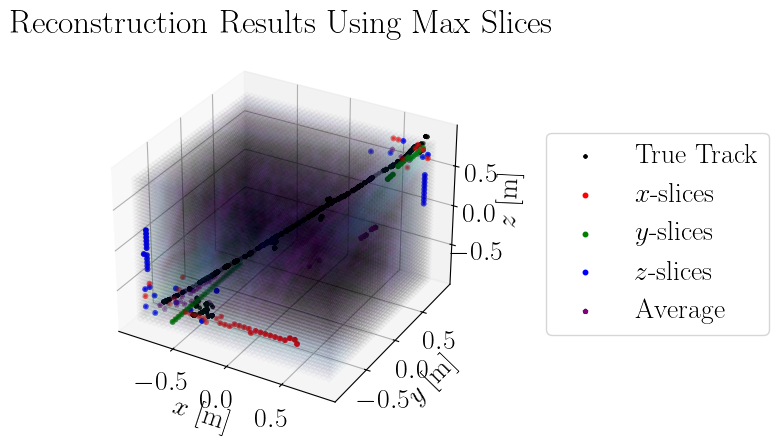

In [23]:
# %matplotlib qt
# %matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
voxelGrid = ax.scatter(grid_pos[:,0]/1000,
                       grid_pos[:,1]/1000,
                       grid_pos[:,2]/1000,
                       c=grid[grid >= 0],
                       cmap='viridis',
                       marker='D',
                       alpha=0.02,
                       s=10,
                       norm=LogNorm())  # Use LogNorm for log scale
track_true = ax.scatter(primary_true[:,0]/1000,
                        primary_true[:,1]/1000,
                        primary_true[:,2]/1000,
                        c='black',
                        marker='x',
                        s=5,
                        label='True Track',
                        linewidth=2)
track_reco_X = ax.scatter(X_max[:,0]/1000,
                          X_max[:,1]/1000,
                          X_max[:,2]/1000,
                          c='r',
                          marker='o',
                          s=5,
                          label='$x$-slices',
                          linewidth=2)
track_reco_Y = ax.scatter(Y_max[:,0]/1000,
                          Y_max[:,1]/1000,
                          Y_max[:,2]/1000,
                          c='g',
                          marker='o',
                          s=5,
                          label='$y$-slices',
                          linewidth=2)
track_reco_Z = ax.scatter(Z_max[:,0]/1000,
                          Z_max[:,1]/1000,
                          Z_max[:,2]/1000,
                          c='b',
                          marker='o',
                          s=5,
                          label='$z$-slices',
                          linewidth=2)
track_reco = ax.scatter(avg_max[:,0]/1000,
                        avg_max[:,1]/1000,
                        avg_max[:,2]/1000,
                        c='purple',
                        marker='*',
                        s=5,
                        label='Average',
                        linewidth=2)
# track_reco_line = ax.plot(pts_lin[:,0],
#                           pts_lin[:,1],
#                           pts_lin[:,2],
#                           c='gray',
#                           marker='o',
#                           markersize=5,
#                           label='pts_lin',
#                           linewidth=2)
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_title('Reconstruction Results Using Max Slices')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm())
sm.set_array(grid[grid > 0])
ax.legend(loc='center right', bbox_to_anchor=(1.8, 0.5))
# cbar = fig.colorbar(sm, ax=ax, label='Color Bar (Log Scale)')
fig.savefig('../figures/trackReconstruction_max_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_81364/4197188346.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


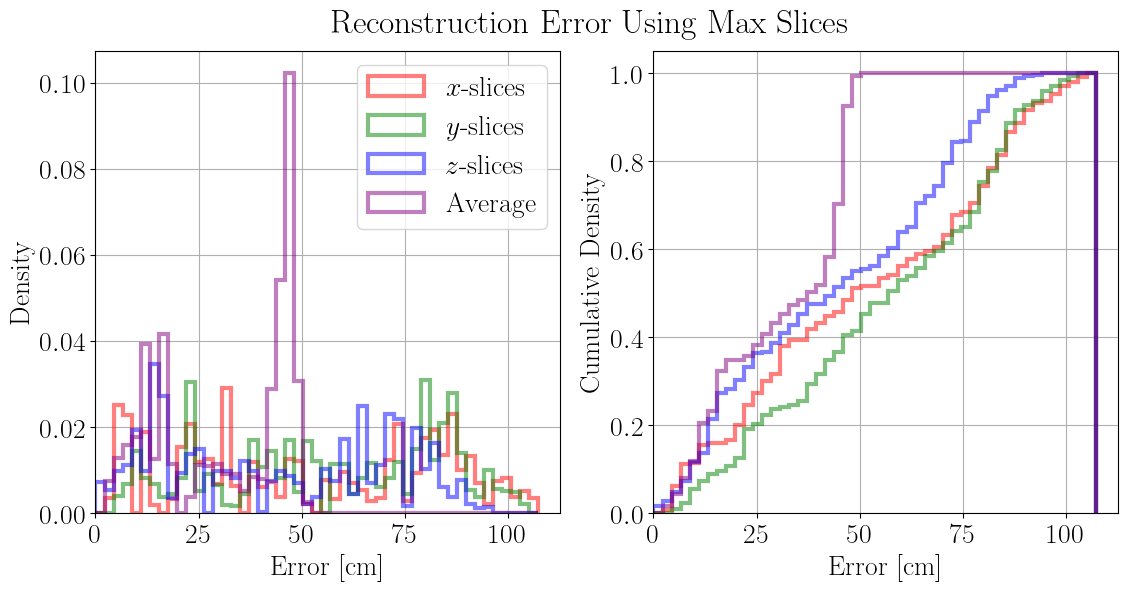

In [24]:
# %matplotlib inline

distances_X = cdist(primary_true, X_max)
distances_X = np.min(distances_X, axis=1)

distances_Y = cdist(primary_true, Y_max)
distances_Y = np.min(distances_Y, axis=1)

distances_Z = cdist(primary_true, Z_max)
distances_Z = np.min(distances_Z, axis=1)

distances_pts = cdist(primary_true, avg_max)
distances_pts = np.min(distances_pts, axis=1)

# pts_lin_true = np.array(df_primary['position'].to_list()).reshape(-1,3)
# pts_lin_true = pts_lin_true[np.where((pts_lin_true[:, 0] < np.max(pts_lin[:,0])) & (pts_lin_true[:, 1] < np.max(pts_lin[:,1])) & (pts_lin_true[:, 2] < np.max(pts_lin[:,2]))
#                                    & (pts_lin_true[:, 0] > np.min(pts_lin[:,0])) & (pts_lin_true[:, 1] > np.min(pts_lin[:,1])) & (pts_lin_true[:, 2] > np.min(pts_lin[:,2])))]
# distances_pts_lin = cdist(np.array(df_primary['position'].to_list()).reshape(-1,3), pts_lin)
# distances_pts_lin = np.min(distances_pts_lin, axis=1)

fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(13.2, 6))
scale = 10
lw = 3
bins = np.linspace(0, np.max([np.max(distances_X/scale), np.max(distances_Y/scale), np.max(distances_Z/scale), np.max(distances_pts/scale)]), 50)

ax_1.hist(distances_X  /scale, bins=bins, color='r'     , alpha=0.5, label='$x$-slices', histtype='step', cumulative=False, density=True, linewidth=lw)
ax_1.hist(distances_Y  /scale, bins=bins, color='g'     , alpha=0.5, label='$y$-slices', histtype='step', cumulative=False, density=True, linewidth=lw)
ax_1.hist(distances_Z  /scale, bins=bins, color='b'     , alpha=0.5, label='$z$-slices', histtype='step', cumulative=False, density=True, linewidth=lw)
ax_1.hist(distances_pts/scale, bins=bins, color='purple', alpha=0.5, label='Average'   , histtype='step', cumulative=False, density=True, linewidth=lw)

ax_2.hist(distances_X  /scale, bins=bins, color='r'     , alpha=0.5, label='$x$-slices', histtype='step', cumulative=True, density=True, linewidth=lw)
ax_2.hist(distances_Y  /scale, bins=bins, color='g'     , alpha=0.5, label='$y$-slices', histtype='step', cumulative=True, density=True, linewidth=lw)
ax_2.hist(distances_Z  /scale, bins=bins, color='b'     , alpha=0.5, label='$z$-slices', histtype='step', cumulative=True, density=True, linewidth=lw)
ax_2.hist(distances_pts/scale, bins=bins, color='purple', alpha=0.5, label='Average'   , histtype='step', cumulative=True, density=True, linewidth=lw)

# ax.hist(distances_pts_lin, bins=bins, color='gray', alpha=0.5, label='pts_lin', histtype='step', cumulative=cum, density=True, linewidth=2)

fig.suptitle('Reconstruction Error Using Max Slices', y=0.95)

ax_1.set_xlabel('Error [cm]')
ax_1.set_ylabel('Density')
ax_1.set_xlim(xmin=0)
ax_1.grid()
ax_1.legend(loc='upper right')

ax_2.set_xlabel('Error [cm]')
ax_2.set_ylabel('Cumulative Density')
ax_2.set_xlim(xmin=0)
ax_2.grid()

fig.savefig('../figures/trackReconstruction_maxError_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()

  0%|          | 0/9270 [00:00<?, ?it/s]

100%|██████████| 9270/9270 [00:00<00:00, 84679.90it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_81364/2458982419.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


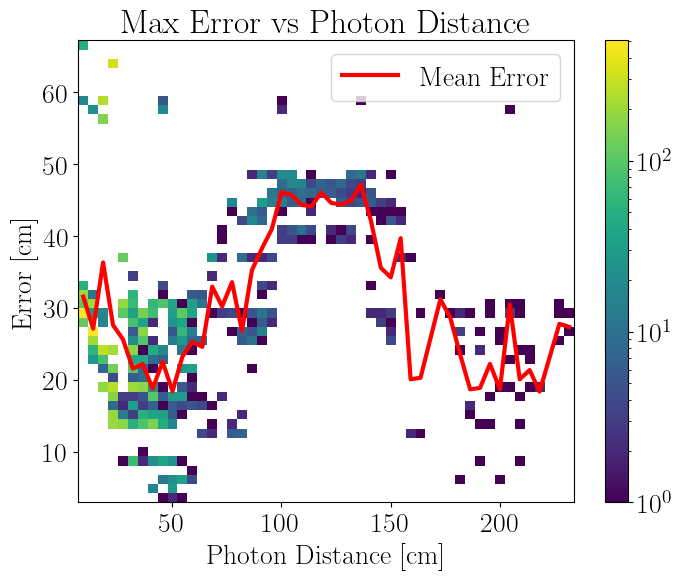

In [25]:
relativeVectors = []
errors = []
for i in tqdm.tqdm(range(len(df_hits))):
    relativeVectors.append(df_hits['relativeVector_r'].iloc[i]/scale)
    initialPosition = df_hits['initialPosition'].iloc[i]
    error = cdist([initialPosition], avg_max)
    error = np.min(error, axis=1)[0]/scale
    errors.append(error)
relativeVectors = np.array(relativeVectors)
errors = np.array(errors)

fig, ax = plt.subplots(figsize=(8, 6))
h, xedges, yedges, _ = ax.hist2d(
    relativeVectors,
    errors,
    norm=LogNorm(),
    bins=50
)
yaverage = []
xaverage = []
for i in range(h.shape[1]):
    if np.sum(h[i,:]) != 0:
        yaverage.append(np.average(yedges[:-1], weights=h[i,:]))
        xaverage.append(xedges[i] + (xedges[i+1] - xedges[i])/2)

ax.plot(
    xaverage,
    yaverage,
    color='r',
    linewidth=3,
    label='Mean Error'
)
ax.set_xlabel('Photon Distance [cm]')
ax.set_ylabel('Error [cm]')
ax.set_title('Max Error vs Photon Distance')
fig.colorbar(ax.collections[0]) 
ax.legend(loc='upper right')

fig.savefig('../figures/trackReconstruction_maxErrorVsPhotonDistance_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()